In [11]:
pip install optuna

In [12]:
pip install catboost

In [13]:
# pip install optuna lightgbm catboost shap

# --- 0. Setup, Import e Configurazione ---
import sys
import subprocess
try:
    print("Tentativo di installazione di LightGBM, CatBoost e SHAP...")
    # Se necessario, decommentare:
    # subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm", "catboost", "shap", "--quiet"])
    print("Installazione completata o librerie già presenti.")
except Exception as e:
    print(f"Attenzione: Impossibile installare alcune librerie: {e}")

# --- Import delle librerie ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
import lightgbm as lgbm

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# --- Configurazione Generale ---
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Lista globale per i risultati dei modelli
global results
results = []

Tentativo di installazione di LightGBM, CatBoost e SHAP...
Installazione completata o librerie già presenti.


In [14]:
# --- 1. Caricamento e Pulizia del Dataset ---
print("--- 1. Caricamento e Pulizia del Dataset ---")
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns = housing.feature_names)
df['med_house_val'] = housing.target




# Pulizia e Rinominazione delle colonne
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df = df.rename(columns={
    "medinc": "med_inc", "houseage": "house_age", "averooms": "ave_rooms",
    "avebedrms": "ave_bedrms", "aveoccup": "ave_occup",
})

# Outlier Detection (Metodo IQR, k=1.5)
num_features = ['med_inc', 'house_age', 'ave_rooms', 'ave_bedrms', 'population', 'ave_occup', 'med_house_val']

def get_outlier_mask(dataframe, cols=num_features, k=1.5):
    mask = pd.DataFrame(False, index=dataframe.index, columns=cols)
    for col in cols:
        q1 = dataframe[col].quantile(0.25)
        q3 = dataframe[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k*iqr
        upper = q3 + k*iqr
        mask[col] = (dataframe[col] < lower) | (dataframe[col] > upper)
    return mask.any(axis=1)

before_count = df.shape[0]
mask = get_outlier_mask(df)
df = df[~mask].dropna()
after_count = df.shape[0]

print(f"Righe dopo la rimozione degli outlier: {after_count} (rimossi {before_count - after_count})")

--- 1. Caricamento e Pulizia del Dataset ---
Righe dopo la rimozione degli outlier: 16312 (rimossi 4328)


In [15]:
# --- 2. Feature Engineering Avanzato (Migliorato) ---
print("\n--- 2. Feature Engineering Avanzato (Migliorato) ---")
# Punti di ancoraggio per il fit quadratico (Curva della Costa)
_LAT = np.array([41.8, 39.0, 37.7, 36.6, 34.4, 34.0, 32.7])
_LON = np.array([-124.2, -123.7, -122.5, -121.9, -120.3, -118.5, -117.2])
_COAST_COEFFS = np.polyfit(_LAT, _LON, deg=2)
SF_LAT, SF_LON = 37.7749, -122.4194

def _coast_lon(lat):
    a, b, c = _COAST_COEFFS
    return a*lat*lat + b*lat + c

def classify_location(lat, lon):
    coast_at_lat = _coast_lon(lat)
    coast_buffer = 1
    inland_shift = 2.3
    inland_at_lat = coast_at_lat + inland_shift

    if lon <= coast_at_lat + coast_buffer:
        return "coast"
    elif lon >= inland_at_lat:
        return "inland"
    else:
        return "middle"

df["position"] = df.apply(lambda row: classify_location(row['latitude'], row['longitude']), axis=1)
df["lon_from_coast"] = df["longitude"] - df.apply(lambda row: _coast_lon(row['latitude']), axis=1)

# NUOVA FEATURE: Distanza da San Francisco
df["dist_from_sf"] = np.sqrt(
    (df['latitude'] - SF_LAT)**2 + (df['longitude'] - SF_LON)**2
)

# Rapporti e Densità
df["bedrooms_per_room"] = df["ave_bedrms"] / df["ave_rooms"]
df["rooms_per_house"] = df["ave_rooms"]
df["pop_per_house"] = df["ave_occup"]

# Popolazione per Cella (Densità Locale)
def add_population_per_cell(df, lat_bin=0.1, lon_bin=0.1):
    df = df.copy()
    df["_lat_bin"] = (df["latitude"] // lat_bin) * lat_bin
    df["_lon_bin"] = (df["longitude"] // lon_bin) * lon_bin

    pop_map = (
        df.groupby(["_lat_bin", "_lon_bin"])["population"]
        .sum()
        .reset_index()
        .rename(columns={"population": "pop_per_cell"})
    )

    df = df.merge(pop_map, on=["_lat_bin", "_lon_bin"], how="left")
    return df.drop(columns=["_lat_bin", "_lon_bin"])

df = add_population_per_cell(df)
print(f"Nuove Feature Aggiunte: lon_from_coast, dist_from_sf, bedrooms_per_room, pop_per_house, pop_per_cell, position")


--- 2. Feature Engineering Avanzato (Migliorato) ---
Nuove Feature Aggiunte: lon_from_coast, dist_from_sf, bedrooms_per_room, pop_per_house, pop_per_cell, position


In [16]:
# --- 3. Preprocessing: Split dei Dati e Modelli Base ---
print("\n--- 3. Preprocessing: Split dei Dati e Modelli Base ---")

# Passaggio 1: Applicazione One-Hot Encoding
df_processed = pd.get_dummies(df, columns=['position'], drop_first=True)

# Passaggio 2: Separazione finale di Feature (X) e Target (y)
X = df_processed.drop(columns=['med_house_val'])
y = df_processed['med_house_val'].reset_index(drop=True)
print(f"Dimensione X dopo OHE: {X.shape}")

# Divisione train/test (80-20)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Split Secondario per Optuna (75% del train full è training, 25% è validation)
X_opt_train, X_opt_val, y_opt_train, y_opt_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)
print(f"Train set (Full): {len(X_train_full)} campioni | Test set: {len(X_test)} campioni | Optuna Validation: {len(X_opt_val)} campioni")

# Identificazione delle colonne per lo Stacking/Scaling
NUMERIC_FEATURES = X.columns.tolist()
OHE_FEATURES = ['position_inland', 'position_middle']
# Togliamo Lat/Lon e OHE dallo scaling (Lat/Lon sono coordinate, OHE sono binarie)
SCALABLE_FEATURES = [col for col in NUMERIC_FEATURES if col not in OHE_FEATURES + ['latitude', 'longitude']]

# Funzione ausiliaria per Optuna
def get_best_params_checked(study, name):
    print(f"{name} best value: {study.best_value:.4f}")
    return study.best_params


--- 3. Preprocessing: Split dei Dati e Modelli Base ---
Dimensione X dopo OHE: (16312, 16)
Train set (Full): 13049 campioni | Test set: 3263 campioni | Optuna Validation: 3263 campioni


In [17]:
# --- 4a. Definizione Funzioni Obiettivo Optuna ---

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 1500), # Aumentato range
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True), # Range più conservativo
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 0.5, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 0.5, log=True),
        'n_jobs': -1, 'random_state': 42, 'objective': 'reg:squarederror'
    }
    model = XGBRegressor(**params)
    model.fit(X_opt_train, y_opt_train, eval_set=[(X_opt_val, y_opt_val)], verbose=False)
    y_pred = model.predict(X_opt_val)
    return np.sqrt(mean_squared_error(y_opt_val, y_pred))

def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 400, 1500), # Aumentato range
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True), # Range più conservativo
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 5.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_seed': 42, 'verbose': 0, 'allow_writing_files': False
    }
    model = CatBoostRegressor(**params)
    model.fit(X_opt_train, y_opt_train, eval_set=[(X_opt_val, y_opt_val)], early_stopping_rounds=20)
    y_pred = model.predict(X_opt_val)
    return np.sqrt(mean_squared_error(y_opt_val, y_pred))

def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 1500), # Aumentato range
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True), # Range più conservativo
        'num_leaves': trial.suggest_int('num_leaves', 32, 256),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 0.5, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 0.5, log=True),
        'n_jobs': -1, 'verbose': -1, 'random_state': 42
    }
    model = LGBMRegressor(**params)
    # Importiamo lgbm per l'early stopping se necessario, ma usiamo la versione di sklearn
    model.fit(X_opt_train, y_opt_train, eval_set=[(X_opt_val, y_opt_val)])
    y_pred = model.predict(X_opt_val)
    return np.sqrt(mean_squared_error(y_opt_val, y_pred))

In [18]:
# --- 4b. Esecuzione Ottimizzazione Optuna ---
print("\n--- 4b. Ottimizzazione Iperparametri (XGB, CAT, LGBM) ---")

N_TRIALS = 35

print("1. Inizializzazione Studi...")
study_xgb = optuna.create_study(direction='minimize')
study_cat = optuna.create_study(direction='minimize')
study_lgbm = optuna.create_study(direction='minimize')

print(f"\n--- Avvio Optuna (XGBoost) - {N_TRIALS} trial ---")
study_xgb.optimize(objective_xgb, n_trials=N_TRIALS, show_progress_bar=True)

print(f"\n--- Avvio Optuna (CatBoost) - {N_TRIALS} trial ---")
study_cat.optimize(objective_cat, n_trials=N_TRIALS, show_progress_bar=True)

print(f"\n--- Avvio Optuna (LightGBM) - {N_TRIALS} trial ---")
study_lgbm.optimize(objective_lgbm, n_trials=N_TRIALS, show_progress_bar=True)

# Raccolta dei migliori parametri
best_xgb_params = get_best_params_checked(study_xgb, 'XGBoost')
best_xgb_params.update({'n_jobs': -1, 'random_state': 42, 'objective': 'reg:squarederror'})

best_cat_params = get_best_params_checked(study_cat, 'CatBoost')
best_cat_params.update({'verbose': 0, 'allow_writing_files': False, 'random_state': 42})

best_lgbm_params = get_best_params_checked(study_lgbm, 'LightGBM')
best_lgbm_params.update({'n_jobs': -1, 'verbose': -1, 'random_state': 42})

print(f"\nBest RMSE Val (Optuna) -> XGB: {study_xgb.best_value:.4f} | CAT: {study_cat.best_value:.4f} | LGBM: {study_lgbm.best_value:.4f}")


--- 4b. Ottimizzazione Iperparametri (XGB, CAT, LGBM) ---
1. Inizializzazione Studi...

--- Avvio Optuna (XGBoost) - 35 trial ---


  0%|          | 0/35 [00:00<?, ?it/s]


--- Avvio Optuna (CatBoost) - 35 trial ---


  0%|          | 0/35 [00:00<?, ?it/s]


--- Avvio Optuna (LightGBM) - 35 trial ---


  0%|          | 0/35 [00:00<?, ?it/s]

XGBoost best value: 0.3829
CatBoost best value: 0.3805
LightGBM best value: 0.3820

Best RMSE Val (Optuna) -> XGB: 0.3829 | CAT: 0.3805 | LGBM: 0.3820


In [19]:
# --- 5. Costruzione e Training Stacking Regressor ---
print("\n--- 5. Costruzione Stacking Regressor con Preprocessing Selettivo ---")
#

# 1. Trasformatore per i modelli Lineari/KNN
# Applica Standard Scaler solo alle feature che beneficiano (escludendo Lat/Lon e OHE)
numeric_pipeline = make_column_transformer(
    (StandardScaler(), SCALABLE_FEATURES),
    ('passthrough', ['latitude', 'longitude', 'position_inland', 'position_middle']), # Lat/Lon e OHE non scalate
    remainder='passthrough'
)

# 2. Definizione Level 0 (Base Models)
estimators = [
    ('xgb', XGBRegressor(**best_xgb_params)),
    ('cat', CatBoostRegressor(**best_cat_params)),
    ('lgbm', LGBMRegressor(**best_lgbm_params)),
    # Pipeline per Ridge (necessita di Scaling)
    ('ridge_pipe', make_pipeline(
        numeric_pipeline,
        RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])
    )),
    # Random Forest potenziato (non necessita di Scaling)
    ('rf', RandomForestRegressor(n_estimators=500, max_depth=12, max_features=0.7, random_state=42, n_jobs=-1))
]

# 3. Definizione Level 1 (Meta Model) - ElasticNet regolarizzata
meta_learner = ElasticNet(alpha=0.0005, l1_ratio=0.9, max_iter=10000, random_state=42)

stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

print(f"Addestramento Stacking in corso con {len(estimators)} Base Models...")
stacking_regressor.fit(X_train_full, y_train_full)
print("Addestramento Stacking completato.")


--- 5. Costruzione Stacking Regressor con Preprocessing Selettivo ---
Addestramento Stacking in corso con 5 Base Models...
Addestramento Stacking completato.


In [20]:
# --- 6. Valutazione Finale Stacking Ensemble ---
print("\n--- 6. Valutazione Finale Ensemble ---")

preds_stacking = stacking_regressor.predict(X_test)
rmse_stacking = np.sqrt(mean_squared_error(y_test, preds_stacking))
r2_stacking = r2_score(y_test, preds_stacking)

# Aggiorna la lista globale dei risultati
global results
results.append({'Modello': 'Ensemble (Stacking)', 'R²': r2_stacking, 'RMSE': rmse_stacking,
                'MAE': mean_absolute_error(y_test, preds_stacking), 'MSE': mean_squared_error(y_test, preds_stacking)})

print("-" * 40)
print(f"STACKING FINAL RMSE: {rmse_stacking:.4f}")
print(f"STACKING FINAL R2:   {r2_stacking:.4f}")
print("-" * 40)
print(f"Obiettivo RMSE <= 0.32: {'Sì' if rmse_stacking <= 0.32 else 'No'}")
print(f"Obiettivo RMSE <= 0.31: {'Sì' if rmse_stacking <= 0.31 else 'No'}")


# Ispezione Pesi Meta-Learner (Importanza)
print("\nPesi Assegnati dal Meta-Modello (Level 1):")
model_names = [name.upper() for name, _ in estimators]
coeffs = stacking_regressor.final_estimator_.coef_
for name, coef in zip(model_names, coeffs):
    print(f"  {name:<10}: {coef:.4f}")

# --- 7. CONFRONTO FINALE DEI MODELLI ---
print('\n--- 7. CONFRONTO FINALE DEI MODELLI ---')
results_df = pd.DataFrame(results).drop_duplicates(subset=['Modello'], keep='last').sort_values(by='R²', ascending=False)
print(results_df)


--- 6. Valutazione Finale Ensemble ---
----------------------------------------
STACKING FINAL RMSE: 0.3384
STACKING FINAL R2:   0.8690
----------------------------------------
Obiettivo RMSE <= 0.32: No
Obiettivo RMSE <= 0.31: No

Pesi Assegnati dal Meta-Modello (Level 1):
  XGB       : 0.1586
  CAT       : 0.5698
  LGBM      : 0.4925
  RIDGE_PIPE: 0.0000
  RF        : -0.2264

--- 7. CONFRONTO FINALE DEI MODELLI ---
               Modello        R²      RMSE       MAE       MSE
0  Ensemble (Stacking)  0.868972  0.338429  0.227028  0.114534


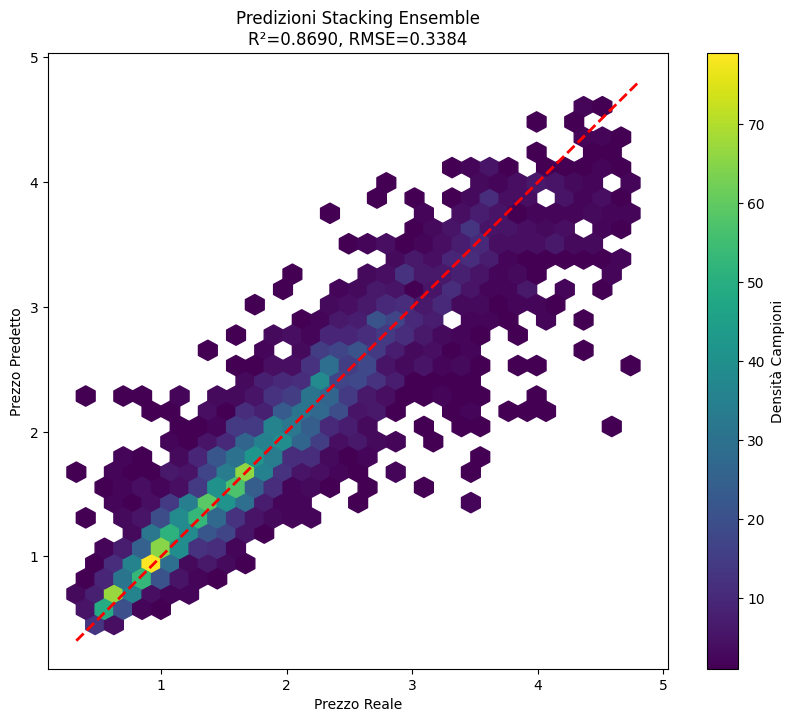


Pipeline completata con Feature Engineering avanzata e Stacking Ensemble ottimizzato.


In [21]:
# --- 8. Visualizzazione Finale ---
fig, ax = plt.subplots(figsize=(10,8))
hb = ax.hexbin(y_test, preds_stacking, gridsize=30, cmap='viridis', mincnt=1)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
cb = plt.colorbar(hb, ax=ax)
cb.set_label('Densità Campioni')
ax.set_xlabel('Prezzo Reale')
ax.set_ylabel('Prezzo Predetto')
ax.set_title(f'Predizioni Stacking Ensemble\nR²={r2_stacking:.4f}, RMSE={rmse_stacking:.4f}')
plt.show()

print('\nPipeline completata con Feature Engineering avanzata e Stacking Ensemble ottimizzato.')

In [22]:
# --- 5a. Definizione Smart Soft Selector (Mixture of Experts) ---
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_predict
from xgboost import XGBClassifier

class SmartSoftModelSelector(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, selector_model=None):
        self.estimators = estimators
        self.selector_model = selector_model if selector_model else XGBClassifier(
            n_estimators=200, max_depth=6, learning_rate=0.05,
            tree_method='hist', device='gpu', n_jobs=-1, random_state=42
        )
        self.model_names = [name for name, _ in estimators]

    def fit(self, X, y):
        # Training modelli base
        self.fitted_estimators_ = []
        for name, model in self.estimators:
            model.fit(X, y)
            self.fitted_estimators_.append(model)

        # Generazione OOF Predictions
        errors = pd.DataFrame()
        for name, model in self.estimators:
            oof_preds = cross_val_predict(model, X, y, cv=5, n_jobs=1)
            errors[name] = np.abs(y - oof_preds)

        # Target per il gating network: quale modello sbaglia meno
        y_best_model_idx = errors.idxmin(axis=1).apply(lambda x: self.model_names.index(x))

        # Training del gating network
        self.selector_model.fit(X, y_best_model_idx)
        return self

    def predict(self, X):
        base_preds = np.column_stack([model.predict(X) for model in self.fitted_estimators_])
        weights = self.selector_model.predict_proba(X)
        return np.sum(base_preds * weights, axis=1)

# --- 5b. Aggiunta del Residual Corrector ---
from catboost import CatBoostRegressor

class ResidualCorrectedMoE(BaseEstimator, RegressorMixin):
    def __init__(self, base_moe_model, corrector_model=None):
        self.base_moe_model = base_moe_model
        self.corrector_model = corrector_model if corrector_model else CatBoostRegressor(
            iterations=500,
            depth=6,
            learning_rate=0.03,
            l2_leaf_reg=5,
            task_type='CPU',
            devices='0',
            verbose=0,
            allow_writing_files=False,
            random_state=42
        )

    def fit(self, X, y):
        # OOF Predictions dal modello base
        oof_preds = cross_val_predict(self.base_moe_model, X, y, cv=5, n_jobs=1)
        residuals = y - oof_preds
        self.corrector_model.fit(X, residuals)
        return self

    def predict(self, X):
        base_pred = self.base_moe_model.predict(X)
        correction = self.corrector_model.predict(X)
        return base_pred + correction

In [23]:
# --- 5c. Costruzione del nuovo MoE con Residual Corrector ---
estimators_list = [
    ('xgb', XGBRegressor(**best_xgb_params)),
    ('cat', CatBoostRegressor(**best_cat_params)),
    ('lgbm', LGBMRegressor(**best_lgbm_params)),
    # Possiamo opzionalmente aggiungere Ridge e RandomForest
    ('ridge_pipe', make_pipeline(numeric_pipeline, RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0]))),
    ('rf', RandomForestRegressor(n_estimators=500, max_depth=12, max_features=0.7,
                                 random_state=42, n_jobs=-1))
]

moe_model = SmartSoftModelSelector(estimators=estimators_list)
moe_model.fit(X_train_full, y_train_full)

# Residual correction
final_system = ResidualCorrectedMoE(base_moe_model=moe_model)
final_system.fit(X_train_full, y_train_full)

ResidualCorrectedMoE(base_moe_model=SmartSoftModelSelector(estimators=[('xgb',
                                                                        XGBRegressor(base_score=None,
                                                                                     booster=None,
                                                                                     callbacks=None,
                                                                                     colsample_bylevel=None,
                                                                                     colsample_bynode=None,
                                                                                     colsample_bytree=0.9228596958724262,
                                                                                     device=None,
                                                                                     early_stopping_rounds=None,
                                                                                     enable_categorical=False,
                                                                                     eval_metric=None,
                                                                                     feature_types=None,
                                                                                     feature_weights=None,
                                                                                     gamma=None,
                                                                                     gr...
                                                                                        interaction_constraints=None,
                                                                                        learning_rate=0.05,
                                                                                        max_bin=None,
                                                                                        max_cat_threshold=None,
                                                                                        max_cat_to_onehot=None,
                                                                                        max_delta_step=None,
                                                                                        max_depth=6,
                                                                                        max_leaves=None,
                                                                                        min_child_weight=None,
                                                                                        missing=nan,
                                                                                        monotone_constraints=None,
                                                                                        multi_strategy=None,
                                                                                        n_estimators=200,
                                                                                        n_jobs=-1,
                                                                                        num_parallel_tree=None, ...)),
                     corrector_model=<catboost.core.CatBoostRegressor object at 0x7c00a3319670>)


RISULTATI FINALI CON MoE + RESIDUAL CORRECTION
RMSE: 0.35036
R² : 0.85957
MAE : 0.23326


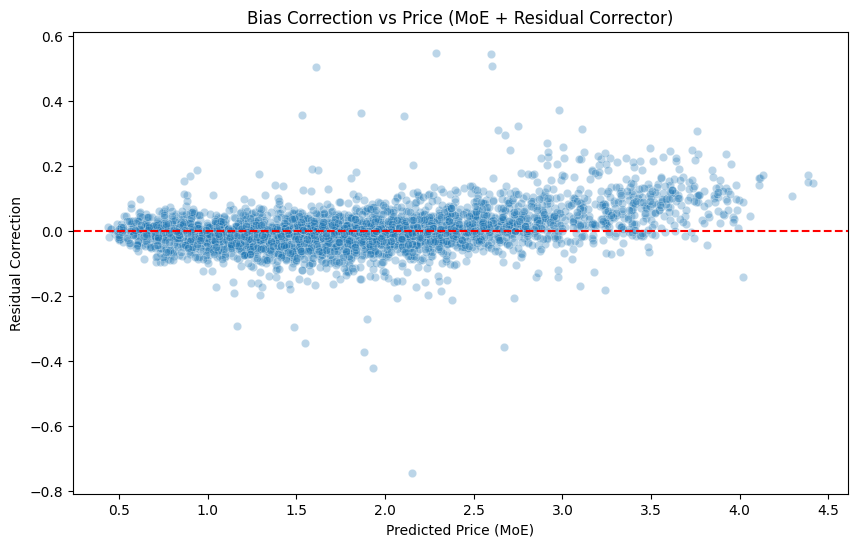

In [24]:
# --- 6. Valutazione Finale ---
y_pred_final = final_system.predict(X_test)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2_final = r2_score(y_test, y_pred_final)
mae_final = mean_absolute_error(y_test, y_pred_final)

print("\n==========================================")
print("RISULTATI FINALI CON MoE + RESIDUAL CORRECTION")
print("==========================================")
print(f"RMSE: {rmse_final:.5f}")
print(f"R² : {r2_final:.5f}")
print(f"MAE : {mae_final:.5f}")
print("==========================================")

# Plot residual correction
corrections_test = final_system.corrector_model.predict(X_test)
base_preds_test = final_system.base_moe_model.predict(X_test)
plt.figure(figsize=(10,6))
sns.scatterplot(x=base_preds_test, y=corrections_test, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Bias Correction vs Price (MoE + Residual Corrector)")
plt.xlabel("Predicted Price (MoE)")
plt.ylabel("Residual Correction")
plt.show()

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA



In [26]:
# --- 5. Costruzione Stacking Regressor con PCA ---
print("\n--- 5. Stacking Regressor con PCA ---")

# 🔹 Modifica PCA aggiunta qui
numeric_pipeline_pca = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95)   # <-- PCA mantiene 95% varianza
)

estimators = [
    ('xgb', XGBRegressor(**best_xgb_params)),
    ('cat', CatBoostRegressor(**best_cat_params)),
    ('lgbm', LGBMRegressor(**best_lgbm_params)),
    ('ridge_pipe', make_pipeline(numeric_pipeline_pca, RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0]))), # <-- PCA applicata qui
    ('rf', RandomForestRegressor(n_estimators=500, max_depth=12, max_features=0.7, random_state=42, n_jobs=-1))
]

meta_learner = ElasticNet(alpha=0.0005, l1_ratio=0.9, max_iter=10000, random_state=42)
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

stacking_regressor.fit(X_train_full, y_train_full)



--- 5. Stacking Regressor con PCA ---


StackingRegressor(cv=5,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9228596958724262,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,...
                               Pipeline(steps=[('pipeline',
                                                Pipeline(steps=[('standardscaler',
                                                                 StandardScaler()),
                                                                ('pca',
                                                                 PCA(n_components=0.95))])),
                                               ('ridgecv',
                                                RidgeCV(alphas=[0.01, 0.1, 1.0,
                                                                10.0]))])),
                              ('rf',
                               RandomForestRegressor(max_depth=12,
                                                     max_features=0.7,
                                                     n_estimators=500,
                                                     n_jobs=-1,
                                                     random_state=42))],
                  final_estimator=ElasticNet(alpha=0.0005, l1_ratio=0.9,
                                             max_iter=10000, random_state=42),
                  n_jobs=-1)

In [27]:
# --- 5a. Smart Soft Selector + Residual Corrector ---
moe_model = SmartSoftModelSelector(estimators_list)
moe_model.fit(X_train_full, y_train_full)

final_system = ResidualCorrectedMoE(base_moe_model=moe_model)
final_system.fit(X_train_full, y_train_full)

ResidualCorrectedMoE(base_moe_model=SmartSoftModelSelector(estimators=[('xgb',
                                                                        XGBRegressor(base_score=None,
                                                                                     booster=None,
                                                                                     callbacks=None,
                                                                                     colsample_bylevel=None,
                                                                                     colsample_bynode=None,
                                                                                     colsample_bytree=0.9228596958724262,
                                                                                     device=None,
                                                                                     early_stopping_rounds=None,
                                                                                     enable_categorical=False,
                                                                                     eval_metric=None,
                                                                                     feature_types=None,
                                                                                     feature_weights=None,
                                                                                     gamma=None,
                                                                                     gr...
                                                                                        interaction_constraints=None,
                                                                                        learning_rate=0.05,
                                                                                        max_bin=None,
                                                                                        max_cat_threshold=None,
                                                                                        max_cat_to_onehot=None,
                                                                                        max_delta_step=None,
                                                                                        max_depth=6,
                                                                                        max_leaves=None,
                                                                                        min_child_weight=None,
                                                                                        missing=nan,
                                                                                        monotone_constraints=None,
                                                                                        multi_strategy=None,
                                                                                        n_estimators=200,
                                                                                        n_jobs=-1,
                                                                                        num_parallel_tree=None, ...)),
                     corrector_model=<catboost.core.CatBoostRegressor object at 0x7c00a331bec0>)

In [28]:
# --- 6. Valutazione Finale ---
y_pred_final = final_system.predict(X_test)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2_final = r2_score(y_test, y_pred_final)
mae_final = mean_absolute_error(y_test, y_pred_final)

print("\n==========================================")
print("RISULTATI FINALI CON MoE + RESIDUAL CORRECTION")
print("==========================================")
print(f"RMSE: {rmse_final:.5f}")
print(f"R² : {r2_final:.5f}")
print(f"MAE : {mae_final:.5f}")
print("==========================================")


RISULTATI FINALI CON MoE + RESIDUAL CORRECTION
RMSE: 0.35036
R² : 0.85957
MAE : 0.23326


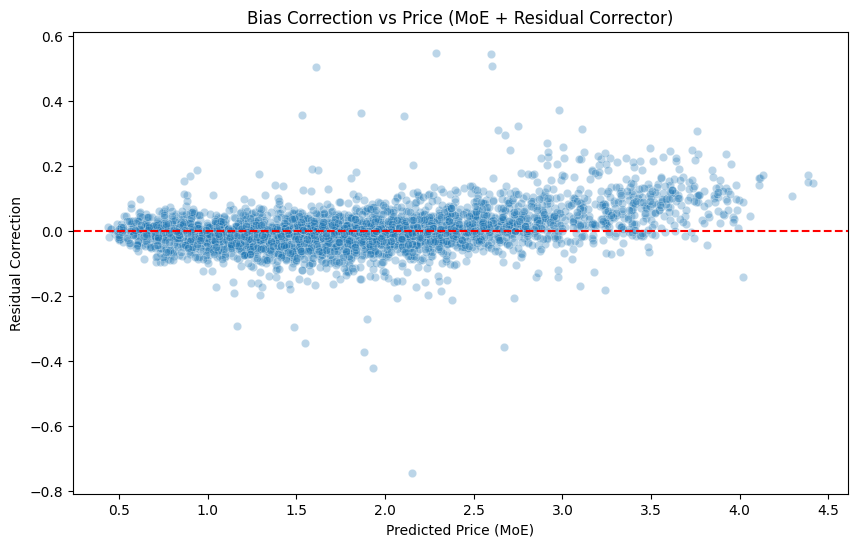

In [29]:
# Plot residual correction
corrections_test = final_system.corrector_model.predict(X_test)
base_preds_test = final_system.base_moe_model.predict(X_test)
plt.figure(figsize=(10,6))
sns.scatterplot(x=base_preds_test, y=corrections_test, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Bias Correction vs Price (MoE + Residual Corrector)")
plt.xlabel("Predicted Price (MoE)")
plt.ylabel("Residual Correction")
plt.show()